In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import gzip
import pickle
from nuplan.planning.training.preprocessing.feature_builders.vector_set_map_feature_builder import VectorSetMapFeatureBuilder
from nuplan.planning.training.preprocessing.features.vector_set_map import VectorSetMap
import os
from matplotlib import pyplot as plt
import hydra
import tempfile
from pathlib import Path
from nuplan.planning.script.builders.worker_pool_builder import build_worker
from nuplan.planning.script.builders.scenario_builder import extract_scenarios_from_dataset
from hydra.utils import instantiate

/home/users/jingyu.qian/horizon-nuplan/nuplan/common/maps/maps_datatypes.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [ ]:
# Location of path with all training configs
CONFIG_PATH = '../../../hoplan/nuplan_extent/planning/script/config/'
CONFIG_NAME = 'horizon_training'

# Create a temporary directory to store the cache and experiment artifacts
SAVE_DIR = Path(tempfile.gettempdir()) / 'tutorial_nuplan_framework'  # optionally replace with persistent dir
EXPERIMENT = 'training_raster_experiment'
JOB_NAME = 'train_default_raster'
LOG_DIR = str(SAVE_DIR / EXPERIMENT / JOB_NAME)

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'group={str(SAVE_DIR)}',
    f'cache.cache_path={str(SAVE_DIR)}/cache',
    f'experiment_name={EXPERIMENT}',
    f'job_name={JOB_NAME}',
    'py_func=train',
    '+training=training_gameformer',  # raster model that consumes ego, agents and map raster layers and regresses the ego's trajectory
    'scenario_builder=nuplan',  # use nuplan mini database
    'scenario_filter.scenario_tokens=["ea551a576f0a5de4"]',  # Choose 500 scenarios to train with
    'lightning.trainer.params.accelerator=ddp_spawn',  # ddp is not allowed in interactive environment, using ddp_spawn instead - this can bottleneck the data pipeline, it is recommended to run training outside the notebook
    'lightning.trainer.params.max_epochs=10',
    'data_loader.params.batch_size=8',
    'data_loader.params.num_workers=8',
    'worker=sequential',
])


/home/users/jingyu.qian/miniconda3/envs/nuplan/lib/python3.9/site-packages/hydra/_internal/config_loader_impl.py:213: UserWarning: provider=hydra.searchpath in main, path=nuplan_extent.planning.script.config.splitter is not available.
  warnings.warn(


In [ ]:
worker = build_worker(cfg)

In [ ]:
scenario = extract_scenarios_from_dataset(cfg, worker)

scenario = scenario[0]

In [ ]:
map_builder = instantiate(cfg.model.feature_builders[0])

target_builder = instantiate(cfg.model.target_builders[0])

In [ ]:
feature = map_builder.get_features_from_scenario(scenario)

/home/users/jingyu.qian/horizon-nuplan/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
/home/users/jingyu.qian/horizon-nuplan/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]
/home/users/jingyu.qian/horizon-nuplan/nuplan/common/maps/nuplan_map/utils.py:413: RuntimeWarning: invalid value encountered in cast
  return elements.iloc[np.where(elements[column_label].to_numpy().astype(int) == int(desired_value))]


In [13]:
target = target_builder.get_targets(scenario, 0)
print(target)
goal = feature.mission_goal
print(goal)

Trajectory(data=array([[ 4.10109186e+00, -1.55371847e-02, -4.28551156e-03],
       [ 8.24175739e+00, -4.72035520e-02, -8.06126837e-03],
       [ 1.24393425e+01, -8.47836956e-02, -1.07554691e-02],
       [ 1.67476673e+01, -1.41131863e-01, -1.25204511e-02],
       [ 2.12139645e+01, -2.00203955e-01, -1.23384530e-02],
       [ 2.58284492e+01, -2.38940462e-01, -9.71989613e-03],
       [ 3.05467548e+01, -2.83069670e-01, -8.04113131e-03],
       [ 3.53600426e+01, -3.12887520e-01, -3.91112128e-03],
       [ 4.02280846e+01, -3.31993937e-01, -5.19906683e-03],
       [ 4.51226616e+01, -3.41772586e-01, -6.42079487e-03],
       [ 5.00501137e+01, -3.44043791e-01, -6.66127913e-03],
       [ 5.50150070e+01, -3.72695774e-01, -6.75753504e-03],
       [ 6.00058212e+01, -3.97691309e-01, -4.99669882e-03],
       [ 6.50297241e+01, -3.91728669e-01, -2.47202301e-03],
       [ 7.00760880e+01, -3.88848603e-01,  1.50345021e-03],
       [ 7.51529083e+01, -3.67819250e-01,  5.92376711e-03]], dtype=float32))
tensor(

In [11]:
route_polylines = scenario.future_pathway_custom()

(-75.02118896332104, 819.7756338181207, -10.157557035726494, 40.90377528446261)

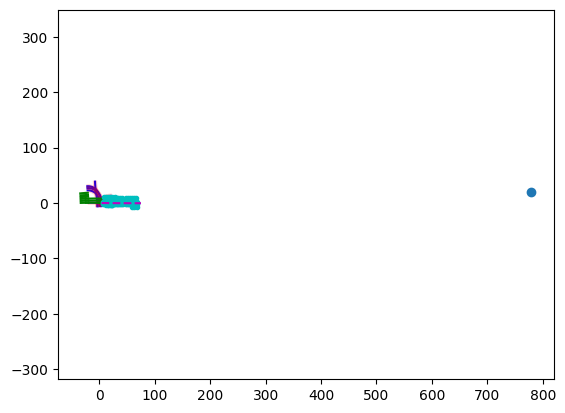

In [15]:
for element in feature.coords["LANE"][0]:
    plt.plot(element[:, 0], element[:, 1], 'b-')
for element in feature.coords["LEFT_BOUNDARY"][0]:
    plt.plot(element[:, 0], element[:, 1], 'r-', alpha=0.2)
for element in feature.coords["RIGHT_BOUNDARY"][0]:
    plt.plot(element[:, 0], element[:, 1], 'r-', alpha=0.2)
    
for element in feature.coords['ROUTE_LANES'][0]:
    plt.plot(element[:, 0], element[:, 1], 'g-')
    
for element in route_polylines[:-1]:
    plt.plot(element[:, 0], element[:, 1], 'c.-')
    
plt.plot(target.data[:, 0], target.data[:, 1], 'm--')

plt.plot(goal[0], goal[1], 'o')

plt.axis('equal')